# Домашнее задание к занятию
## "Кластеризация"

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN

In [2]:
# Загружаем датасет
data = pd.read_excel('geo.xlsx')
data.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


In [3]:
# Получаем основную информацию о данных в датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     108806 non-null  int64  
 1   x              108806 non-null  float64
 2   y              108806 non-null  float64
 3   comment_class  108806 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 3.3 MB


In [4]:
# Определяем количество пропусков для каждого признака
data.isna().sum()

Unnamed: 0       0
x                0
y                0
comment_class    0
dtype: int64

Пропуски в данных отсутствуют, типы данных признаков соответствуют значениям, которые в них должны находится.

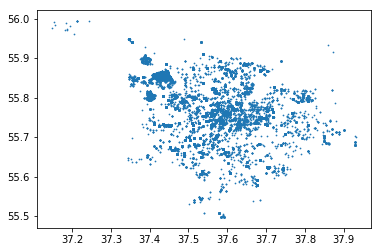

In [5]:
# Визуализируем распределение комментариев жителей на карте
plt.scatter(data.x, data.y, cmap='autumn', s=0.5)

Подберём количество кластеров для KMeans без учёта голоса (за и против вместе).

In [6]:
# Подбираем количество кластеров для наших данных и находим сумму квадратов расстояний объектов классов до их центроид
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k, random_state=0)
    clusters_kmeans = clf_kmeans.fit(data[['x', 'y']])
    k_inertia.append(clf_kmeans.inertia_)

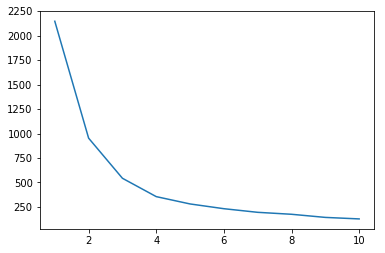

In [7]:
# Визуализируем зависимость суммы квадратов расстояний объектов классов до их центроид от количества кластеров
plt.plot(ks, k_inertia)

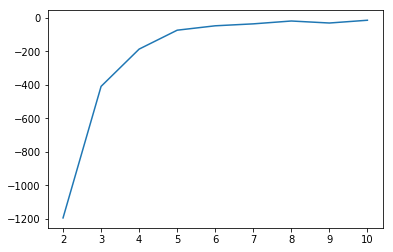

In [8]:
# Вычислим дискретную разность n-го порядка вместе с заданной осью и визуализируем полученный результат
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

Определим оптимальное количество кластеров по формуле:

$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [9]:
diff_r = diff[1:] / diff[:-1]

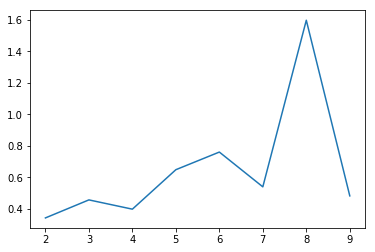

In [10]:
# Визуализируем результат
plt.plot(ks[1:-1], diff_r)

In [11]:
# Найдём оптимальное количество кластеров
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

Таким образом, для разделения города на районы безотносительно голосов оптимально использовать 2 кластера.

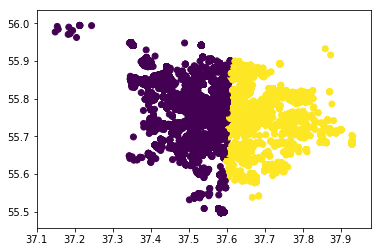

In [12]:
# Визуально разделим город на районы безотносительно голосов с оптимальным количеством кластеров
clf_kmeans_1 = KMeans(n_clusters=2, random_state=0)
clusters_kmeans_1 = clf_kmeans_1.fit(data[['x', 'y']])
plt.scatter(data.x, data.y, c=clf_kmeans_1.predict(data[['x', 'y']]))

Аналогично выполним работу для скопления голосов за.

In [13]:
# Оставим только значения с голосами "за"
data_1 = data.loc[data['comment_class'] == 1]
data_1.head()

,Unnamed: 0,x,y,comment_class
28,28,37.588916,55.741982,1
45,45,37.589311,55.734273,1
46,46,37.558526,55.728758,1
47,47,37.566431,55.731794,1
61,61,37.589311,55.734273,1


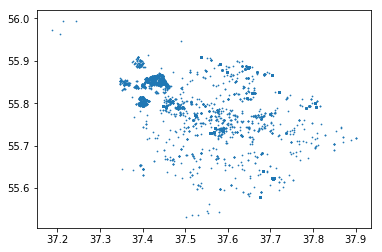

In [14]:
# Визуализируем распределение комментариев жителей на карте
plt.scatter(data_1.x, data_1.y, cmap='autumn', s=0.5)

In [15]:
# Подбираем количество кластеров для наших данных и находим сумму квадратов расстояний объектов классов до их центроид
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k, random_state=0)
    clusters_kmeans = clf_kmeans.fit(data_1[['x', 'y']])
    k_inertia.append(clf_kmeans.inertia_)

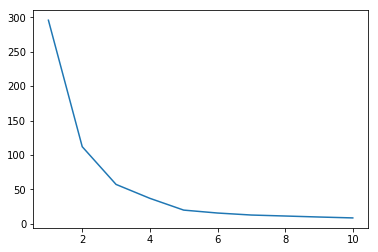

In [16]:
# Визуализируем зависимость суммы квадратов расстояний объектов классов до их центроид от количества кластеров
plt.plot(ks, k_inertia)

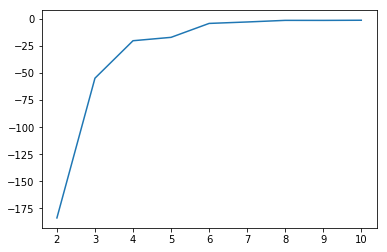

In [17]:
# Вычислим дискретную разность n-го порядка вместе с заданной осью и визуализируем полученный результат
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

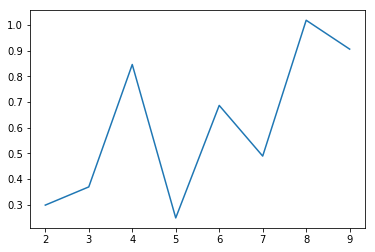

In [18]:
# Определим оптимальное количество кластеров и визуализируем результат
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [19]:
# Найдём оптимальное количество кластеров
k_opt = ks[np.argmin(diff_r)+1]
k_opt

5

Оптимальное количество кластеров для разделения города на районы с голосами "за" - 5.

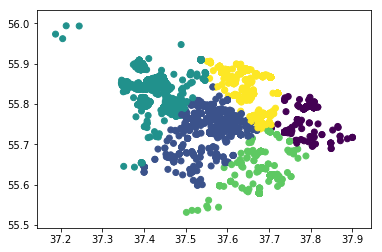

In [20]:
# Визуально разделим город на районы с голосами "за" с оптимальным количеством кластеров
clf_kmeans_2 = KMeans(n_clusters=5, random_state=0)
clusters_kmeans_2 = clf_kmeans_2.fit(data_1[['x', 'y']])
plt.scatter(data_1.x, data_1.y, c=clf_kmeans_2.predict(data_1[['x', 'y']]))

Аналогично выполним работу для скопления голосов "против".

In [21]:
# Оставим только значения с голосами "против"
data_2 = data.loc[data['comment_class'] == -1]
data_2.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


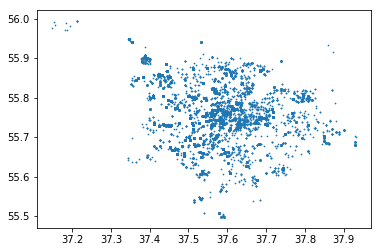

In [22]:
# Визуализируем распределение комментариев жителей на карте
plt.scatter(data_2.x, data_2.y, cmap='autumn', s=0.5)

In [23]:
# Подбираем количество кластеров для наших данных и находим сумму квадратов расстояний объектов классов до их центроид
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k, random_state=0)
    clusters_kmeans = clf_kmeans.fit(data_2[['x', 'y']])
    k_inertia.append(clf_kmeans.inertia_)

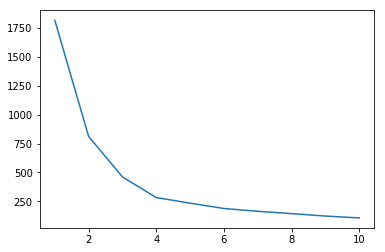

In [24]:
# Визуализируем зависимость суммы квадратов расстояний объектов классов до их центроид от количества кластеров
plt.plot(ks, k_inertia)

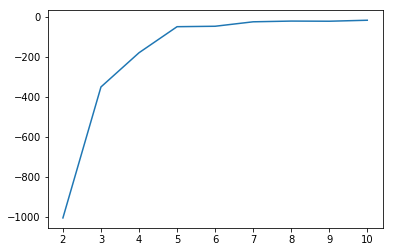

In [25]:
# Вычислим дискретную разность n-го порядка вместе с заданной осью и визуализируем полученный результат
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

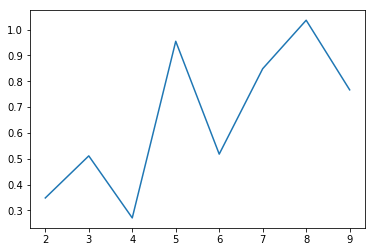

In [26]:
# Определим оптимальное количество кластеров и визуализируем результат
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [27]:
# Найдём оптимальное количество кластеров
k_opt = ks[np.argmin(diff_r)+1]
k_opt

4

Оптимальное количество кластеров для разделения города на районы с голосами "против" - 4.

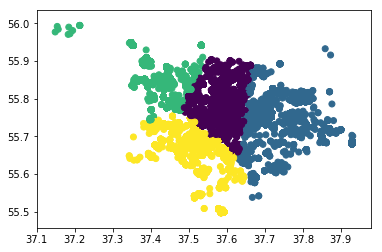

In [28]:
# Визуально разделим город на районы с голосами "против" с оптимальным количеством кластеров
clf_kmeans_3 = KMeans(n_clusters=4, random_state=0)
clusters_kmeans_3 = clf_kmeans_3.fit(data_2[['x', 'y']])
plt.scatter(data_2.x, data_2.y, c=clf_kmeans_3.predict(data_2[['x', 'y']]))

Найдём наиболее активные в голосовании районы.

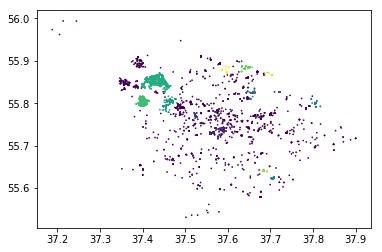

In [29]:
# Обучаем модель для райнов с голосами "за"
dbscan = DBSCAN(eps=0.01, min_samples=100)
y = dbscan.fit_predict(data_1[['x', 'y']])
plt.figure()
plt.scatter(data_1.x, data_1.y, c=y, s=0.5)
plt.show()

На представленном рисунке наиболее активные районы выделены зеленым цветом.

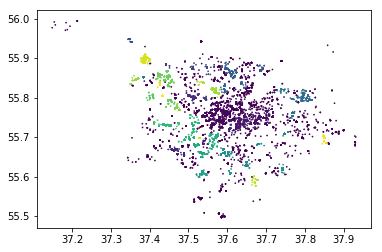

In [30]:
# Обучаем модель для райнов с голосами "против"
dbscan = DBSCAN(eps=0.01, min_samples=100)
y = dbscan.fit_predict(data_2[['x', 'y']])
plt.figure()
plt.scatter(data_2.x, data_2.y, c=y, s=0.5)
plt.show()

На представленном рисунке наиболее активные районы выделены зеленым цветом.

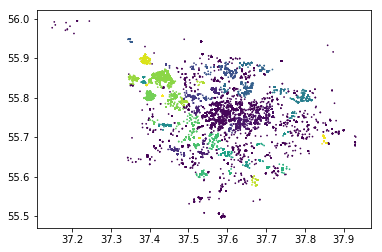

In [31]:
# Обучаем модель для райнов без разделения по голосам
dbscan = DBSCAN(eps=0.01, min_samples=100)
y = dbscan.fit_predict(data[['x', 'y']])
plt.figure()
plt.scatter(data.x, data.y, c=y, s=0.5)
plt.show()

На представленном рисунке наиболее активные районы выделены зеленым цветом.